## Question 1


In [24]:
import cv2 as cv
import numpy as np

input_image = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_GRAYSCALE)


number_of_sigmas = 20  # Number of sigmas
min_sigma = 1.0
max_sigma = 10.0
threshold = 0.01

sigmas = np.linspace(min_sigma, max_sigma, number_of_sigmas)

detected_blobs = []
radius = []

def laplasian_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2

    for i in range(size):
        for j in range(size):
            kernel[i, j] = ((i - center) ** 2 + (j - center) ** 2 - 2 * sigma ** 2) * np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2 * sigma ** 2))

    return kernel * sigma**2 # Normalization
    
def image_thresholding(image, threshold):
    thresholded_image = np.zeros(image.shape)
    thresholded_image[image > threshold] = 1
    return thresholded_image # output is an image with boolean values

for i in range(sigmas.shape[0]):
    sigma = sigmas[i]
    radius.append((np.sqrt(2)*sigma))
    kernel_size = int(max_sigma*3)  
    convolved_image = cv.filter2D(input_image, -1, laplasian_kernel(kernel_size, sigmas[i]))
    detected_blobs.append(image_thresholding(convolved_image, threshold))





for i, image in enumerate(detected_blobs):
    cv.imshow(f"Scale {i+1}", image)

cv.waitKey(0)
cv.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

input_image = cv2.imread('images/the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_GRAYSCALE)

# Define the number of scales and min/max sigma values

min_sigma = 1.0
max_sigma = 50.0
num_scales = int(max_sigma-min_sigma)

# Create lists to store scale space images and DoG images
scale_space_images = []
difference_of_gaussians = []

# Compute the scale space images
for scale_level in range(num_scales):
    sigma = min_sigma + (max_sigma - min_sigma) * scale_level / (num_scales - 1)
    smoothed_image = cv2.GaussianBlur(input_image, (0, 0), sigmaX=sigma, sigmaY=sigma)
    scale_space_images.append(smoothed_image)

# Compute the Difference of Gaussians (DoG) images
for i in range(len(scale_space_images) - 1):
    difference_of_gaussians.append(np.subtract(scale_space_images[i], scale_space_images[i + 1]))

# Define a threshold for keypoints
threshold = 0.01

# Create an ORB detector (you can use other detectors like SIFT or SURF)
detector = cv2.ORB_create()

# List to store keypoints
keypoints = []

# Loop through the DoG images and find keypoints
for i, dog_image in enumerate(difference_of_gaussians):
    # Find keypoints in the current DoG image
    kp = detector.detect(dog_image)

    # Filter keypoints based on the DoG image values
    kp = [k for k in kp if abs(dog_image[int(k.pt[1]), int(k.pt[0])]) > threshold]

    # Set the scale level of keypoints based on the current DoG image
    for k in kp:
        k.octave = i

    # Add the keypoints to the list
    keypoints.extend(kp)

# Create an output image to draw keypoints
output_image = cv2.drawKeypoints(input_image, keypoints, None, color=(0, 255, 0), flags=0)

# Display the result with a resizable window
cv2.namedWindow('Keypoints', cv2.WINDOW_NORMAL)
cv2.imshow('Keypoints', output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Question 2

### Code given in the question

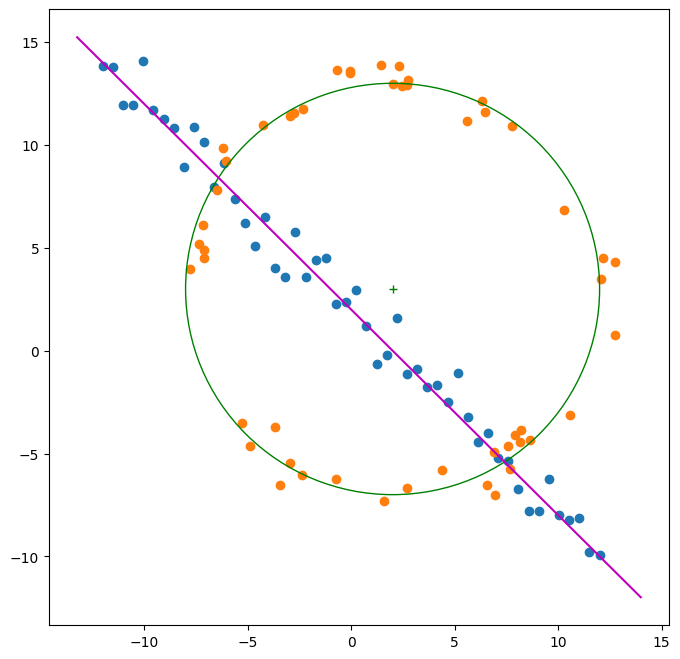

In [ ]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np

# np.random.seed(0)
N = 100
half_n = N//2
r = 10
x0_gt, y0_gt = 2,3 # center
s = r /16
# angle values in radian
t = np.random.uniform(0, 2*np.pi, half_n)
# noise values from 0 to s
n = s*np.random.randn(half_n)
# creating points on a noisy circle 
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))

s = 1
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
# creating points on a noisy line
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line)) #All points

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt) # add circle
ax.plot((x0_gt), (y0_gt), '+', color='g') # add centre of the circle
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')

### Finding RANSAC Line

no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  44 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  44 42.0
no of inliners =  43 42.0
no of inliners =  44 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inliners =  43 42.0
no of inline

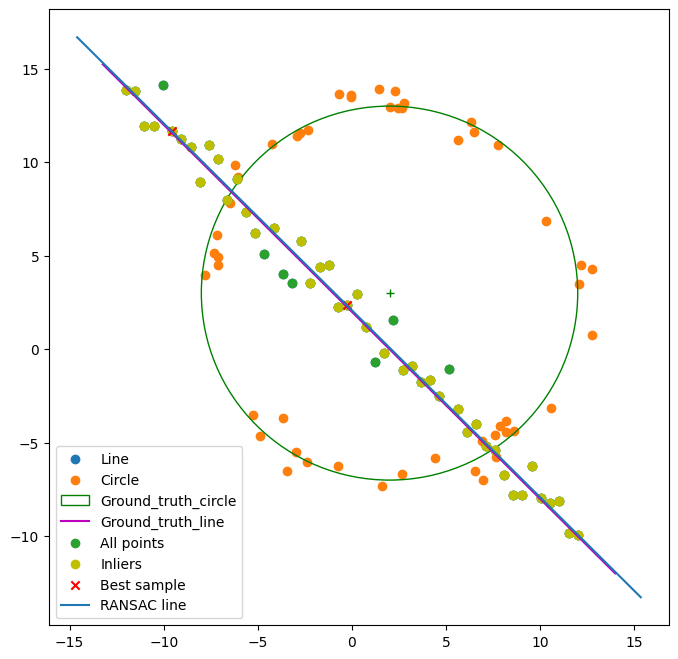

In [ ]:
X = np.vstack((X_circ, X_line)) #All points


# Item 2: Total least squares line fitting with scicpy.optimize with RANSAC
import math
from scipy.optimize import minimize
N = X_line.shape[0] # points
X_ = X_line

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
# returning the error
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))


# Constraint
# x = [a,b]
def g(x):
    return x[0]**2 + x[1]**2 - 1

# maintaining a**2 + b**2 = 1
cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X_, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t


t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.84*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 5000
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample
x0 = np.array([1, 1, 0]) # Initial estimate a,b,d

while (iteration < max_iterations):   
    indices = np.random.randint(0, N, s) # A sample of 2 points selected at random
    
    #return many things but res.x contains a,b,d
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': False})

    #returns indexes of cordinates of inliners
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers

    # print('rex.x: ', res.x)    
    # print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum()) # number of inliners

    if np.sum(inliers_line) > d:
        x0 = res.x
        print('no of inliners = ',np.sum(inliers_line), d)
        # Computing the new model using the inliers
        #return many things but res.x contains a,b,d
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': False})

        #print(res.x, res.fun) # what is fun
        if res.fun < best_error:
            # print('A better model found ... ', res.fun, best_error)
            best_model_line = res.x
            best_error = res.fun
            best_sample_line = X_[indices,:]
            # res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1
     

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt) # add circle
ax.plot((x0_gt), (y0_gt), '+', color='g') # add centre of the circle
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')

ax.scatter(X_line[:,0],X_line[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], marker='x', color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[0]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
plt.legend()

### Finding RANSAC circle

In [ ]:
new_xline = X_line[~best_inliers_line]
new_X = np.vstack((X_circ, new_xline)) #All points

import math
import numpy as np
from scipy.optimize import minimize
N = new_X.shape[0] # points
# X_ = new_X

def circle_tls(x, indices):
    x0, y0, r = x[0], x[1], x[2]
    datapoints = new_X[indices]
    squared_distances = np.sum((datapoints - np.array([x0, y0]))**2, axis=1)
    error = np.abs(squared_distances - r**2)
    return np.sum(error)

def consensus_circle(new_X, x, t):
    xc, yc, r = x[0], x[1], x[2]
    point_to_center = np.sqrt(np.square(new_X[:,0] - xc) + np.square(new_X[:,1] - yc))
    return (point_to_center < r+t) & (point_to_center > r-t)

t = 1.0   # Threshold value to determine data points that are fit well by model.
# increase d to 0.8N
d = 0.8*N   # Number of close data points required to assert that a model fits well to data.
s = 3       # Minimum number of data points required to estimate model parameters.

cons_circle = ({'type': 'ineq', 'fun': lambda x: x[2] - t})

inliers_circle = []        # Indinces of the inliers
max_iterations = 500
iteration = 0
best_model_circle = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_circle = []    # Three-point sample leading to the best model computation
res_only_with_sample_circle = [] # Result (xc, yc, r) only using the best sample
best_inliers_circle = []   # Inliers of the model computed form the best sample
x0 = np.array([1, 1, 1]) # Initial estimate xc, yc, r

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of 3 points selected at random

    #return many things but res.x contains a,b,d
    res = minimize(fun = circle_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons_circle, options={'disp': False})

    #returns indexes of cordinates of inliners
    inliers_circle = consensus_circle(new_X, res.x, t) # Computing the inliers

    # print('rex.x: ', res.x)    
    # print('Iteration = ', iteration, '. No. inliners = ', inliers_circle.sum()) # number of inliners

    if np.sum(inliers_circle) > d:
        x0 = res.x
        print('no of inliners for circle: ', np.sum(inliers_circle), d)
        # Computing the new model using the inliers
        #return many things but res.x contains a,b,d
        res = minimize(fun = circle_tls, args = inliers_circle, x0 = x0, tol= 1e-6, constraints=cons_circle, options={'disp': False})

        # print(res.x, res.fun) # what is fun
        if res.fun < best_error:
            # print('A better model found ... ', res.x, res.fun)
            best_model_circle = res.x
            best_error = res.fun
            best_sample_circle = new_X[indices,:]
            # res_only_with_sample_circle = x0
            best_inliers_circle = inliers_circle

    iteration += 1

print('best model found: ', best_model_circle, ', no of inliners = ', np.sum(best_inliers_circle))



no of inliners for circle:  47 45.6
no of inliners for circle:  46 45.6
no of inliners for circle:  46 45.6
no of inliners for circle:  46 45.6
no of inliners for circle:  46 45.6
best model found:  [2.1893539  3.16277678 9.85943152] , no of inliners =  46


### Plotting RANSAC line and RANSAC circle

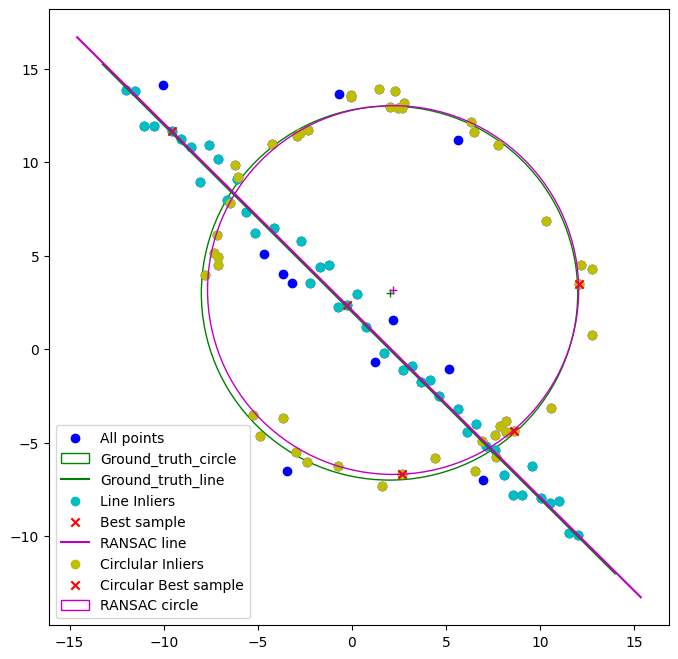

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(X_line[:,0], X_line[:,1], label='Line', color='b')
ax.scatter(X[:,0], X[:,1], label='All points', color='b')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt) # add circle
ax.plot((x0_gt), (y0_gt), '+', color='g') # add centre of the circle
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='g', label='Ground_truth_line')

# ax.scatter(X_line[:,0],X_line[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='c', label='Line Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], marker='x', color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[0]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line', color='m')

# ax.scatter(new_X[:,0],new_X[:,1], label='All points')
ax.scatter(new_X[best_inliers_circle,0],new_X[best_inliers_circle,1], color='y', label='Circlular Inliers')
ax.scatter(best_sample_circle[:,0],best_sample_circle[:,1], marker='x', color='r', label='Circular Best sample')
circle_r = plt.Circle((best_model_circle[0], best_model_circle[1]), best_model_circle[2], color='m', fill=False, label='RANSAC circle')
ax.add_patch(circle_r)
ax.plot((best_model_circle[0]), (best_model_circle[1]), '+', color='m') # for the centre of RANSAC circle
plt.legend()

## Question 3

### Selecting points in the building image

#### Note that points should be in the correct order

1. Top Left
2. Top Right
3. Bottom Right
4. Bottom Left

Clicked Coordinates:
Point 1: (11, 267)
Point 2: (139, 255)
Point 3: (138, 305)
Point 4: (12, 318)


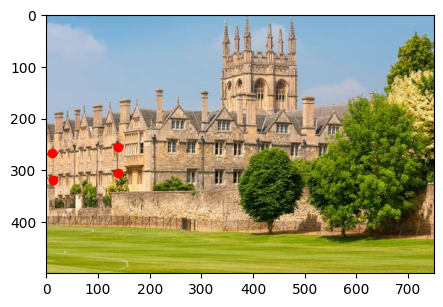

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

clicked_coordinates = []
click_count = 0

# Mouse callback function
def mouse_callback(event, x, y, flags, param):
    global clicked_coordinates, click_count

    # If left mouse button is clicked, capture the coordinates and draw a marker
    if event == cv.EVENT_LBUTTONDOWN:
        clicked_coordinates.append((x, y))
        click_count += 1
        cv.circle(image, (x, y), 5, (0, 0, 255), -1)  # Draw a red circle as a marker
        cv.imshow("Image", image)

        # If four clicks are captured, stop capturing
        if click_count == 4:
            cv.destroyAllWindows()


image = cv.imread('images/collage.jpg') 
cv.imshow("Image", image)

cv.setMouseCallback("Image", mouse_callback)

cv.waitKey(0)

# Output the coordinates
print("Clicked Coordinates:")
for i, (x, y) in enumerate(clicked_coordinates, start=1):
    print(f"Point {i}: ({x}, {y})")

# display the image with markers in Matplotlib
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
# Set the plot size to 15x15 inches
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(image_rgb)
for (x, y) in clicked_coordinates:
    ax.plot(x, y, 'ro')  # Draw a red marker

plt.show()


### Warping the flag to the image of building

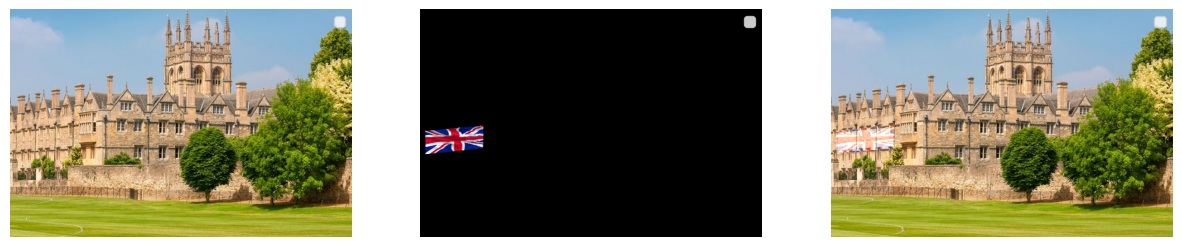

In [ ]:
import matplotlib.pyplot as plt

img_building = cv.imread('images/collage.jpg')
img = cv.cvtColor(img_building, cv.COLOR_BGR2RGB)
img_flag = cv.imread('images/flag2.jpg')

points_building = np.array(clicked_coordinates, dtype=np.float32)

# should be in cliking order
point_flag = np.array([[0, 0], [img_flag.shape[1], 0], [img_flag.shape[1], img_flag.shape[0]], [0, img_flag.shape[0]]], dtype=np.float32) 

# Calculate the homography matrix
homography_matrix, _ = cv.findHomography(point_flag, points_building)

# Warp the flag image
flag_warped = cv.warpPerspective(img_flag, homography_matrix, (img_building.shape[1], img_building.shape[0]))
warped_flag=cv.cvtColor(flag_warped, cv.COLOR_BGR2RGB)

# Adjust transparency
alpha = 0.5 

# # Create the composite image
composite_image = cv.addWeighted(img_building, 1, flag_warped, alpha, 0, dst=img_building)
composite=cv.cvtColor(composite_image, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize=(15,15))

ax[0].imshow(img)
ax[0].axis('off')
ax[0].legend('Image of the building')
ax[1].imshow(warped_flag)
ax[1].axis('off')
ax[1].legend('Image of the building')
ax[2].imshow(composite)
ax[2].axis('off')
ax[2].legend('Image of the building')
plt.show()

### Question 4


In [21]:
import cv2 as cv
import numpy as np

image5 = cv.imread('images/img5.ppm', cv.IMREAD_GRAYSCALE)
image1 = cv.imread('images/img1.ppm', cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints5, descriptors5 = sift.detectAndCompute(image5, None)

bf = cv.BFMatcher()

matches = bf.knnMatch(descriptors1, descriptors5, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)


matched_image = cv.drawMatches(image1, keypoints1, image5, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv.imshow('Matched Image', matched_image)
cv.waitKey(0)
cv.destroyAllWindows()


